In [51]:
import ipywidgets as widgets
from IPython.display import display
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import numpy as np
import shutil
import albumentations as A
import tensorflow.keras.optimizers as optim


In [52]:
images_path = '../dataset/all/images'
images_n_path = '../dataset/all/images_n'
masks_path = '../dataset/all/masks'

train_images_path = '../dataset/train/images'
train_masks_path = '../dataset/train/masks'

val_images_path = '../dataset/val/images'
val_masks_path = '../dataset/val/masks'

test_images_path = '../dataset/test/images'
test_masks_path = '../dataset/test/masks'

B=2
N_CLASSES=2
H,W =240,240
SPLIT_SIZE = 32
SPLIT_COUNT=H//SPLIT_SIZE
N_EPOCHS=135
BATCH_SIZE=32

<p style="font-size:30px;">Copy Positive image from main folder to train and validation folder</p>

In [53]:
images_file_array = np.array(os.listdir(images_path))
len_images = len(os.listdir(images_path))

def move_pos_to_Train_Val(val_size = 0.05):
    val_image_size = int(val_size*len_images)
    val_random_index = np.random.choice(len_images,val_image_size,replace=False)

    mask_train_val = np.ones(len_images,dtype=bool)
    mask_train_val[val_random_index] = False

    val_images_file = images_file_array[val_random_index]
    train_images_file = images_file_array[mask_train_val]

    for val_image_file in val_images_file:
        shutil.copy2(os.path.join(images_path,str(val_image_file)),os.path.join(val_images_path,str(val_image_file)))
        shutil.copy2(os.path.join(masks_path,str(val_image_file)),os.path.join(val_masks_path,str(val_image_file)))
    
    for train_image_file in train_images_file:
        shutil.copy2(os.path.join(images_path,str(train_image_file)),os.path.join(train_images_path,str(train_image_file)))
        shutil.copy2(os.path.join(masks_path,str(train_image_file)),os.path.join(train_masks_path,str(train_image_file)))


    

In [54]:
# moveTo_Train_Val()

<p style="font-size:30px;">Copy Negative image from main folder to train and validation folder</p>

In [55]:
# get count of positive and negative class in train and val
def count_neg_pos_func(path):
    count_neg_pos_class = {}
    
    for mask in os.listdir(path):
        mask_file_path = os.path.join(path,mask)
        mask_read = cv2.imread(mask_file_path,cv2.IMREAD_GRAYSCALE)
        value = np.unique(mask_read)
        if len(value)>1:
            try:
                count = count_neg_pos_class['pos']+1
                count_neg_pos_class['pos'] = count
            except:
                count_neg_pos_class['pos'] = 1
        elif len(value) == 1 and value[-1] == 0:
            try:
                count = count_neg_pos_class['neg']+1
                count_neg_pos_class['neg'] = count
            except:
                count_neg_pos_class['neg'] = 1

    return count_neg_pos_class

# Move Negative Image 
def move_neg_to_train_val():
    train_count_neg_pos_class = count_neg_pos_func(train_masks_path)
    val_count_neg_pos_class = count_neg_pos_func(val_masks_path)

    print(train_count_neg_pos_class)
    print(val_count_neg_pos_class)

    train_pos_count,train_neg_count = train_count_neg_pos_class['pos'],train_count_neg_pos_class['neg']
    val_pos_count,val_neg_count = val_count_neg_pos_class['pos'],val_count_neg_pos_class['neg']

    train_diff_class = np.abs(train_pos_count-train_neg_count)
    val_diff_class = np.abs(val_pos_count-val_neg_count)
     
    images_n_file = os.listdir(images_n_path)
    for idx in range(train_diff_class):
        image_n_file_path = os.path.join(images_n_path,images_n_file[idx])
        to_image_n_file_path = os.path.join(train_images_path,images_n_file[idx])

        if not os.path.exists(to_image_n_file_path):
            shutil.copy2(image_n_file_path,to_image_n_file_path)
        else:
            print("Train Negative File Exists")

    for idx in range(train_diff_class,train_diff_class+val_diff_class):
        image_n_file_path = os.path.join(images_n_path,images_n_file[idx])
        to_image_n_file_path = os.path.join(val_images_path,images_n_file[idx])

        if not os.path.exists(to_image_n_file_path):
            shutil.copy2(image_n_file_path,to_image_n_file_path)
        else:
            print("Val Negative File Exists")



In [56]:
# move_neg_to_train_val()

In [57]:
def move_to_test(test_size = 0.01):
    train_images_file = os.listdir(train_images_path)
    len_test_size = int(len(train_images_file)*test_size)
    random_index = np.random.choice(len(train_images_file),len_test_size,replace=False)
    train_images_file_array = np.array(train_images_file)
    
    random_files = train_images_file_array[random_index]

    for test_file in random_files:
        train_image_path_file = os.path.join(train_images_path,test_file)
        train_mask_path_file = os.path.join(train_masks_path,test_file)

        test_image_path_file = os.path.join(test_images_path,test_file)
        test_mask_path_file = os.path.join(test_masks_path,test_file)

        shutil.move(train_image_path_file,test_image_path_file)
        try:
            shutil.move(train_mask_path_file,test_mask_path_file)
        except:
            pass
        



In [58]:
# move_to_test()

<h1>List Train and Validation Files name</h1>

In [59]:
train_images_file = os.listdir(train_images_path)
train_masks_file = os.listdir(train_masks_path)

val_images_file = os.listdir(val_images_path)
val_masks_file = os.listdir(val_masks_path)


<h1>Get Length train and validation</h1>

In [60]:
len_train_images = len(train_images_file)
# 30614
len_val_images = len(val_images_file)
# 1611



<h1>Print pixel value of masks</h1>

In [61]:
def printPixelMaskValue(index):
    train_image_file = train_images_file[index]
    train_image_file_path = os.path.join(train_masks_path,train_image_file)

    mask = cv2.imread(train_image_file_path)
    print(np.unique(mask,cv2.IMREAD_GRAYSCALE))

printPixelMaskValue(0)
# index_slider = widgets.IntSlider(value=0,min=0,max=len(train_images_file)-1,step=1,description='Mask Pixel Value')
# widgets.interactive(printPixelMaskValue,index = index_slider)

interactive(children=(IntSlider(value=0, description='Mask Pixel Value', max=30290), Output()), _dom_classes=(…

<h1>Count negative and positive data</h1>

In [62]:
def count_neg_pos_func(path):
    count_neg_pos_class = {}
    
    for image in os.listdir(path):
        if os.path.exists(os.path.join(train_masks_path,image)):
            mask_file_path = os.path.join(train_masks_path,image)
            mask_read = cv2.imread(mask_file_path,cv2.IMREAD_GRAYSCALE)
            value = np.unique(mask_read)
            if len(value)>1:
                try:
                    count = count_neg_pos_class['pos']+1
                    count_neg_pos_class['pos'] = count
                except:
                    count_neg_pos_class['pos'] = 1
            elif len(value) == 1 and value[-1] == 0:
                try:
                    count = count_neg_pos_class['neg']+1
                    count_neg_pos_class['neg'] = count
                except:
                    count_neg_pos_class['neg'] = 1
        else:
            try:
                count = count_neg_pos_class['neg']+1
                count_neg_pos_class['neg'] = count
            except:
                count_neg_pos_class['neg'] = 1

    return count_neg_pos_class


<h1>Show Images with defect</h>

In [63]:
def showImage(index):
    train_image_file = train_images_file[index]
    train_image_file_path = os.path.join(train_images_path,train_image_file)
    train_mask_file_path = os.path.join(train_masks_path,train_image_file)


    image = cv2.imread(train_image_file_path,cv2.IMREAD_GRAYSCALE)

    fig,ax = plt.subplots(1,2,figsize = (15,5))

    ax[0].imshow(image)
    ax[0].set_title('Image  %s\n%s'%(train_images_file[index],image.shape))
    ax[0].axis('off')

    print('Mask Exists : %s'%os.path.exists(train_mask_file_path))
    if os.path.exists(train_mask_file_path):
        mask = cv2.imread(train_mask_file_path,cv2.IMREAD_GRAYSCALE)
        ax[1].imshow(mask)
        ax[1].set_title('Mask %s'%train_images_file[index])
        ax[1].axis('off')

    plt.show()

showImage(0)
# index_slider = widgets.IntSlider(value=0,min=0,max=len(train_images_file)-1,step=1,description='Image Index:')
# widgets.interactive(showImage,index = index_slider)

interactive(children=(IntSlider(value=0, description='Image Index:', max=30290), Output()), _dom_classes=('wid…

<h1>Show image with mask</h1>

In [64]:
def showImageWithMask(index):
    fig,axis = plt.subplots(1,3,figsize = (15,5))

    # Load image and mask file paths based on the provided index
    train_image_file = train_images_file[index]
    train_image_file_path = os.path.join(train_images_path,train_image_file)
    train_mask_file_path = os.path.join(train_masks_path,train_image_file)

    # Read the original image in grayscale
    image = cv2.imread(train_image_file_path,cv2.IMREAD_GRAYSCALE)

    # Check if the mask file exists
    if os.path.exists((train_mask_file_path)):
        # Read the mask image in grayscale
        mask_image = cv2.imread(train_mask_file_path,cv2.IMREAD_GRAYSCALE)

        # Find defect area with threshold
        _,thresh = cv2.threshold(mask_image,0,5,cv2.THRESH_BINARY)

        contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        bboxes = []
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            bboxes.append(bbox)
            cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(255, 0, 0),2)
        
        # Draw contours on the original image in green color __ -1 mean all contours
        cv2.drawContours(image,contours,-1,(0,1,0),2)

        axis[1].imshow(mask_image)
        axis[1].set_title('Mask')
        
        axis[2].imshow(thresh)
        axis[2].set_title('Threshold Mask')

        print('Boundry Boxes : ',bboxes)
    
    axis[0].imshow(image)
    axis[0].set_title('Image & Contours\n%s'%train_image_file)

# showImageWithMask(1)
# slider = widgets.IntSlider(value = 1,min = 0,max = len(train_images_file)-1,step=1,description='Image Index:')
# widgets.interactive(showImageWithMask,index = slider)
    
    

interactive(children=(IntSlider(value=1, description='Image Index:', max=30290), Output()), _dom_classes=('wid…

<h1>Data Preparation</h1>

In [65]:
train_ims_paths = []
train_masks_paths = []

val_ims_paths = []
val_masks_paths = []

for image_file in train_images_file:
    train_ims_paths.append(os.path.join(train_images_path,image_file))
    if os.path.exists(os.path.join(train_masks_path,image_file)):
        train_masks_paths.append(os.path.join(train_masks_path,image_file))
    else:
        train_masks_paths.append('None')

for image_file in val_images_file:
    val_ims_paths.append(os.path.join(val_images_path,image_file))
    if os.path.exists(os.path.join(val_masks_path,image_file)):
        val_masks_paths.append(os.path.join(val_masks_path,image_file))
    else:
        val_masks_paths.append('None')

print(train_masks_paths[0])

../dataset/train/masks\0002cc93b_1.png


In [66]:
def preprocess_mask(mask_file):
    bboxes = []
    mask_file = mask_file.decode('utf8')

    # Check if the mask is for training and the file exists in the training path
    if mask_file == 'None':
        return tf.convert_to_tensor(bboxes)
        
    mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(H,W))
    _,thresh = cv2.threshold(mask,0,np.unique(mask)[-1],cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get image dimensions
    width_pic = mask.shape[1]
    height_pic = mask.shape[0]

    for contour in contours:
        x_center,y_center,width,height = cv2.boundingRect(contour)

        # Normalize the bounding box coordinates
        bbox = [
            (x_center + (width / 2)) / width_pic,    # Center x normalized
            (y_center + (height / 2)) / height_pic,  # Center y normalized
            width / width_pic,              # Width normalized
            height / height_pic,            # Height normalized
            1.
        ]
        
        bboxes.append(bbox)
    return tf.convert_to_tensor(bboxes)


In [67]:
def generate_output(bounding_boxes):
    output_label = np.zeros((SPLIT_COUNT,SPLIT_COUNT,N_CLASSES+5))
    for b in range(len(bounding_boxes)):
        grid_x = bounding_boxes[...,b,0]*SPLIT_COUNT
        grid_y = bounding_boxes[...,b,1]*SPLIT_COUNT

        i = int(np.ceil(grid_x)-1)
        j = int(np.ceil(grid_y)-1)

        output_label[i,j] = [1,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3],0.,1.]
    
    # For no defect
    output_label[output_label[..., 0] == 0, 5] = 1.
    

    return tf.convert_to_tensor(output_label,dtype=tf.float32)


In [68]:
# a = generate_output(preprocess_mask(os.path.join(train_masks_path,"0002cc93b_1.png").encode()))


<h2>Make dataset</h2>

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_ims_paths,train_masks_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_ims_paths,val_masks_paths))

<h3>Get Image and BBoxes</h3>

In [70]:
def get_imbboxes(img_path,mask_pth):
    img = tf.io.decode_png(tf.io.read_file(img_path),channels=3)
    img = tf.cast(tf.image.resize(img,(H,W)),dtype=tf.float32)


    bboxes = tf.numpy_function(func = preprocess_mask,inp=[mask_pth],Tout=tf.float32)

    return img,bboxes

In [71]:
train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

<h5>Check Image and BBoxes</h5>

In [72]:
def plot_image_bboxes(index):  
    for i,j in train_dataset.skip(index):
        plt.title("Shape : %s"%i.shape)
        plt.imshow(i/255)
        
        if not j.shape[0]>0:
            break

        j_numpy = j.numpy()
        x_center_norm = j_numpy[:,0]
        y_center_norm = j_numpy[:,1]
        width_normal = j_numpy[:,2]
        height_normal = j_numpy[:,3]

        x = x_center_norm*W
        y = y_center_norm*H
        width = width_normal*W
        height = height_normal*H

        x_min = x-(width/2)
        y_min = y-(height/2)

        x_max = x_min+width
        y_max = y_min+height

        for k in range(len(x_min)):
            x_points = [x_min[k], x_max[k], x_max[k], x_min[k], x_min[k]]
            y_points = [y_min[k], y_min[k], y_max[k], y_max[k], y_min[k]]

            plt.plot(x_points, y_points, color="red")
        
        break   
    
plot_image_bboxes(0)
# slider = widgets.IntSlider(min=0,max = len(train_images_file)-1,step=1,description = 'Index Slider : ')
# widgets.interactive(plot_image_bboxes,index = slider)


interactive(children=(IntSlider(value=0, description='Index Slider : ', max=30290), Output()), _dom_classes=('…

<h3>Albumentation augmented</h3>

In [73]:
transform = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(width=np.random.randint(int(0.9*W),W),
                 height=np.random.randint(int(0.9*H),H),p=0.5),
    A.RandomScale(scale_limit=0.1,interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(H,W)
],bbox_params=A.BboxParams(format='yolo',))

In [74]:
def aug_albument(image,bboxes):
    augmented = transform(image = image,bboxes = bboxes)
    image = augmented['image']
    bboxes = augmented['bboxes']

    return [tf.convert_to_tensor(image,dtype=tf.float32),
            tf.convert_to_tensor(bboxes,dtype=tf.float32)]
    

In [75]:
def process_data(image,bboxes):
    aug = tf.numpy_function(aug_albument,inp=[image,bboxes],Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [76]:
train_dataset = train_dataset.map(process_data)


<h5>Check image and Bboxes after Transform</h5>

(1, 5)


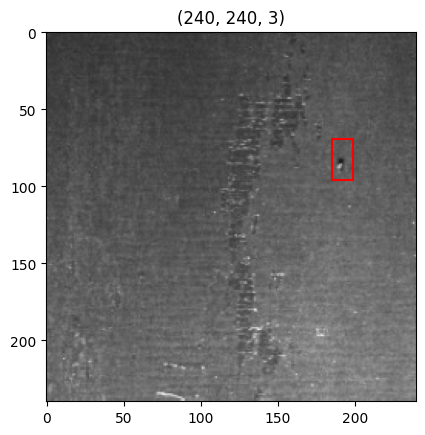

In [77]:
def plot_image_bboxes_after_transform(index):
    for i,j in train_dataset.skip(index):
        plt.title(i.shape)
        plt.imshow(i/255)

        if not j.shape[0]>0:
            print('p')
            break

        print(j.shape)
        x_center_norm = j[...,0]
        y_center_norm = j[...,1]
        width_norm = j[...,2]
        height_norm = j[...,3]

        min_x_norm = x_center_norm-(width_norm/2)
        min_y_norm = y_center_norm-(height_norm/2)
        max_x_norm = min_x_norm+width_norm
        max_y_norm = min_y_norm+height_norm

        min_x = min_x_norm*W
        max_x = max_x_norm*W
        min_y = min_y_norm*H
        max_y = max_y_norm*H


        for rect_idx in range(len(min_x_norm)):
            plt.plot([min_x[rect_idx],min_x[rect_idx]],[min_y[rect_idx],max_y[rect_idx]],'r')
            plt.plot([min_x[rect_idx],max_x[rect_idx]],[min_y[rect_idx],min_y[rect_idx]],'r')
            plt.plot([max_x[rect_idx],max_x[rect_idx]],[min_y[rect_idx],max_y[rect_idx]],'r')
            plt.plot([min_x[rect_idx],max_x[rect_idx]],[max_y[rect_idx],max_y[rect_idx]],'r')

        break

plot_image_bboxes_after_transform(1)
# index_slider = widgets.IntSlider(value=1,min=0,max=len(train_images_file)-1,step=1,description='Image Index:')
# widgets.interactive(plot_image_bboxes_after_transform,index = index_slider)


<h3>Change saturation color and like these for train dataset</h3>

In [78]:
def preprocess_augment(img,y):
    img = tf.image.random_brightness(img,max_delta=50.)
    img = tf.image.random_saturation(img,lower = 0.5,upper=1.5)
    img = tf.image.random_contrast(img,lower=0.5,upper=1.5)
    img = tf.clip_by_value(img,0,255)
    labels = tf.numpy_function(generate_output,inp=[y],Tout=(tf.float32))
    img = tf.cast(img,dtype = tf.float32)
    return img,labels

In [79]:
def preprocess(img,y):
    img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)
    labels = tf.numpy_function(func = generate_output,inp=[y],Tout=(tf.float32))

    return img,labels

In [80]:
train_dataset = train_dataset.map(preprocess_augment)
val_dataset = val_dataset.map(preprocess)

In [81]:
# for x,y in train_dataset:
#     print(y.shape)
#     pass

In [82]:
val_dataset=(
  val_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [83]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE,drop_remainder=True).
  prefetch(tf.data.AUTOTUNE)
)

<h1>Model</h1>

In [84]:
NUM_FILTERS = 512
OUTPUT_DIM = B*5+N_CLASSES

In [85]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False
)
base_model.trainable = False

In [86]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(NUM_FILTERS,kernel_initializer = 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha = 0.1),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(SPLIT_COUNT*SPLIT_COUNT*OUTPUT_DIM,activation='sigmoid'),

    tf.keras.layers.Reshape((SPLIT_COUNT,SPLIT_COUNT,OUTPUT_DIM))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 512)         5898752   
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                      

In [87]:
def compute_iou(boxes1,boxes2):
    box1_t = tf.stack([boxes1[...,0]-boxes1[...,2]/2,
                        boxes1[...,1]-boxes1[...,3]/2,
                        boxes1[...,0]+boxes1[...,2]/2,
                        boxes1[...,3]+boxes1[...,3]/2],axis=-1)

    box2_t = tf.stack([boxes1[...,0]-boxes2[...,2]/2,
                          boxes2[...,1]-boxes2[...,3]/2,
                          boxes2[...,0]+boxes2[...,2]/2,
                          boxes2[...,1]+boxes2[...,3]/2],axis=-1)
    
    lu = tf.maximum(boxes1[...,:2],boxes2[...,:2])
    rd = tf.minimum(boxes1[...,2:],boxes2[...,2:])

    intersection = tf.maximum(0.0,rd-lu)
    inter_square = intersection[...,0]*intersection[...,1]

    square_1 = boxes1[...,2]*boxes1[...,3]
    square_2 = boxes2[...,2]*boxes2[...,3]

    union_square = tf.maximum(square_1+square_2-inter_square,1e-10)
    return tf.clip_by_value(inter_square/union_square,0.0,1.0)


In [88]:
def difference(y,x):
    return tf.reduce_sum(tf.square(y-x))

In [89]:
# imput shape : y_True(BATCH_SIZE , SPLIT_COUNT , SPLIT_COUNT , N_CLASSES+5)
# imput shape : y_pred(BATCH_SIZE , SPLIT_COUNT , SPLIT_COUNT , N_CLASSES+5*B)
def yolo_loss(y_true,y_pred):
    target = y_true[...,0]
    
    y_true_extract = tf.gather_nd(y_true,tf.where(target == 1))
    y_pred_extract = tf.gather_nd(y_pred,tf.where(target == 1))

    rescaler = tf.where(target == 1)*32

    upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros((len(rescaler),2),dtype=tf.int64)],axis=-1)

    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),float(H),float(W)]],repeats=[len(rescaler)],axis=0) * \
                                    tf.cast(y_true_extract[...,1:5],dtype=tf.float32)
    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),float(H),float(W)]],repeats=[len(rescaler)],axis=0) * \
                                    tf.cast(y_pred_extract[...,1:5],dtype=tf.float32)
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),float(H),float(W)]],repeats=[len(rescaler)],axis=0) * \
                                    tf.cast(y_pred_extract[...,5:9],dtype=tf.float32)
    
    target_orig = tf.cast(upscaler_1,tf.float32)+target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1,tf.float32)+pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1,tf.float32)+pred_2_upscaler_2

    mask_bool = tf.greater(compute_iou(target_orig,pred_1_orig),compute_iou(target_orig,pred_2_orig))
    mask_int = tf.cast(mask_bool,tf.int32)

    conf_pred_1 = y_pred_extract[:,0]
    conf_pred_2 = y_pred_extract[:,5]

    conf_preds = tf.stack((conf_pred_1,conf_pred_2),axis=-1)
    mask_index = tf.stack((tf.range(len(rescaler)),mask_int),axis = -1)

    obj_pred = tf.gather_nd(conf_preds,mask_index)
    object_loss = difference(tf.cast(tf.ones(len(rescaler)),dtype = tf.float32),
                    tf.cast(obj_pred,tf.float32))
    
    
    
    '-------------------------------------------------------------------------------'

    y_pred_extract = tf.gather_nd(y_pred,tf.where(target == 0))
    y_target_extract = tf.zeros(len(y_pred_extract),dtype = tf.float32)

    no_object_loss_1 = difference(y_target_extract,y_pred_extract[...,0])
    no_object_loss_2 = difference(y_target_extract,y_pred_extract[...,5])

    no_object_loss = no_object_loss_1+no_object_loss_2

    '-------------------------------------------------------------------------------'

    y_pred_label = tf.reshape(y_pred[...,10:],(-1,2))
    y_true_label = tf.reshape(y_true[...,5:],(-1,2))
    
    class_loss = difference(y_true_label,y_pred_label)

    '-------------------------------------------------------------------------------'    

    bbox_target = tf.gather_nd(y_true[...,1:5],tf.where(target == 1))
    bbox_pred_1 = tf.gather_nd(y_pred[...,1:5],tf.where(target == 1))
    bbox_pred_2 = tf.gather_nd(y_pred[...,6:10],tf.where(target == 1))
    
    bbox_pred = tf.stack((bbox_pred_1,bbox_pred_2),axis=1)
    obj_bbox_pred = tf.gather_nd(bbox_pred,mask_index)

    center_loss = difference(bbox_target[...,:2],obj_bbox_pred[...,:2])
    size_loss = difference(tf.math.sqrt(tf.math.abs(bbox_target[...,2:])),tf.math.sqrt(tf.math.abs(obj_bbox_pred[...,2:])))

    bbox_loss = center_loss+size_loss

    lambda_no_obj = 0.5
    lambda_coord = 5.0

    loss = object_loss + (lambda_no_obj*no_object_loss) + (lambda_coord*bbox_loss) + class_loss
    return loss

In [90]:
# y_pred = tf.random.uniform((1,3,3,12),minval=0,maxval = 1)
y_true = \
   [
   [
        [[0.0, 0.  , 0.  , 0.  , 0.  , 1.0, 0.0],   # Grid (0, 0)
         [1.0, 0.56, 0.89, 0.67, 0.24, 0.0, 1.0],   # Grid (0, 1)
         [0.0, 0.  , 0.  , 0.  , 0.  , 1.0, 0.0]],  # Grid (0, 2)

        [[0.0, 0.34, 0.67, 0.23, 0.45, 1.0, 0.0],   # Grid (1, 0)
         [0.0, 0.  , 0.  , 0.  , 0.  , 1.0, 0.0],   # Grid (1, 1)
         [1.0, 0.78, 0.56, 0.12, 0.89, 0.0, 1.0]],  # Grid (1, 2)

        [[1.0, 0.45, 0.34, 0.56, 0.67, 1.0, 1.0],   # Grid (2, 0)
         [0.0, 0.  , 0.  , 0.  , 0.  , 1.0, 0.0],   # Grid (2, 1)
         [1.0, 0.67, 0.89, 0.23, 0.56, 1.0, 1.0]]   # Grid (2, 2)
   ]
   ] 

y_pred = \
    [
    [
        [[0.05, 0.02, 0.01, 0.03, 0.02, 0.15, 0.02, 0.21, 0.23, 0.52, 0.85, 0.15],       # Grid (0, 0)
         [0.95, 0.58, 0.87, 0.68, 0.22, 0.75, 0.58, 0.67, 0.78, 0.42, 0.15, 0.95],       # Grid (0, 1)
         [0.07, 0.03, 0.02, 0.01, 0.14, 0.17, 0.03, 0.02, 0.01, 0.24, 0.88, 0.12]],      # Grid (0, 2)

        [[0.08, 0.36, 0.66, 0.25, 0.44, 0.38, 0.36, 0.76, 0.25, 0.74, 0.78, 0.22],       # Grid (1, 0)
         [0.02, 0.01, 0.0 , 0.0 , 0.03, 0.12, 0.01, 0.32 , 0.0, 0.53, 0.85, 0.15],       # Grid (1, 1)
         [0.85, 0.76, 0.58, 0.13, 0.84, 0.75, 0.56, 0.38, 0.13, 0.44, 0.12, 0.88]],      # Grid (1, 2)

        [[0.92, 0.44, 0.35, 0.55, 0.65, 0.62, 0.34, 0.25, 0.55, 0.75, 0.72, 0.85],       # Grid (2, 0)
         [0.06, 0.02, 0.01, 0.0 , 0.0 , 0.16, 0.02, 0.01, 0.0 , 0.0 , 0.96, 0.14],       # Grid (2, 1)
         [0.88, 0.68, 0.84, 0.22, 0.57, 0.83, 0.68, 0.84, 0.22, 0.47, 0.65, 0.88]]       # Grid (2, 2)
    ]
    ]
# print(yolo_loss(tf.constant(y_true),tf.constant(y_pred)))

In [91]:
file_path = '../callback/detect_defect.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)


In [92]:
def scheduler(epoch,lr):
    if epoch < 40:
        return 1e-3
    elif epoch>=40 and epoch<80:
        return 5e-4
    else:
        return 1e-4

In [93]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [94]:
model.compile(
    loss = yolo_loss,
    optimizer=optim.Adam(learning_rate = 1e-3)
    )

In [95]:
model.load_weights('../callback/detect_defect.h5')

In [96]:

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     verbose=1,
#     epochs=50,
#     callbacks=[lr_callback,callback]
#     )

<h1>Test Model</h1>

In [97]:
test_image_path = '../dataset/test/images/'
test_images_file = os.listdir(test_image_path)

In [98]:


def model_test(index):
    filename = test_images_file[index]
    test_path=test_image_path+filename

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    selected_output=tf.gather_nd(output,object_positions)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
        for j in range(2):      
            if selected_output[i][j*5]>THRESH:
                output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

                x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
                y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

                x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])
                
                x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
                x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

                if(x_min<=0):x_min=0
                if(y_min<=0):y_min=0
                if(x_max>=W):x_max=W
                if(y_max>=H):y_max=H
                final_boxes.append(
                    [x_min,y_min,x_max,y_max])
                final_scores.append(round(float(selected_output[i][j*5]),3))

    final_boxes=np.array(final_boxes)

    if final_boxes.shape[0]>0:
        nms_boxes=final_boxes[...,0:4]
        
        nms_output=tf.image.non_max_suppression(
            nms_boxes,
            final_scores,
            max_output_size=100,
            iou_threshold=0.2,
            score_threshold=float('-inf')
        )
        
        for i in nms_output:
            cv2.rectangle(
                img,
                (int(final_boxes[i][0]),int(final_boxes[i][1])),
                (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),2)
            
            text ='Score : '+str(final_scores[i])
            size_text = pos_text = cv2.getTextSize(text,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,1)[0]
            
            pos_text = [int(final_boxes[i][0]),int(final_boxes[i][1])]

            if size_text[0]+int(final_boxes[i][0]) > W :pos_text[0] = pos_text[0]-(size_text[0]+int(final_boxes[i][0])-W)
            if np.abs(size_text[1]-int(final_boxes[i][1])) < 0 :pos_text[1] = size_text[1]

            cv2.putText(
                img,
                text,
                pos_text,
                cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(2,225,155),1
                )


    plt.figure(figsize = (8,8))
    if os.path.exists(os.path.join(test_masks_path,filename)):
        plt.subplot(1,2,1)
        plt.imshow(img)
        
        plt.subplot(1,2,2)
        plt.imshow(cv2.imread(os.path.join(test_masks_path,filename),cv2.IMREAD_GRAYSCALE))

    else:
        plt.imshow(img)


                

In [99]:
model_test(10)
# slider = widgets.IntSlider(min = 0,max = len(os.listdir(test_image_path)),step=1,value=0)
# widgets.interactive(model_test,index = slider)

interactive(children=(IntSlider(value=0, description='index', max=305), Output()), _dom_classes=('widget-inter…